In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten 
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import json
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
!unzip "/content/drive/MyDrive/dataset/train_image.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train_images/99f75320d.jpg  
  inflating: train_images/99f9d2375.jpg  
  inflating: train_images/99fd3c6f5.jpg  
  inflating: train_images/9a016fe15.jpg  
  inflating: train_images/9a064450d.jpg  
  inflating: train_images/9a08c2783.jpg  
  inflating: train_images/9a18e4457.jpg  
  inflating: train_images/9a1f7c238.jpg  
  inflating: train_images/9a2523ce9.jpg  
  inflating: train_images/9a3e774ff.jpg  
  inflating: train_images/9a5e9e77c.jpg  
  inflating: train_images/9a5f7a855.jpg  
  inflating: train_images/9a62177bb.jpg  
  inflating: train_images/9a67575cf.jpg  
  inflating: train_images/9a6ac5406.jpg  
  inflating: train_images/9a70057c0.jpg  
  inflating: train_images/9a72fd89e.jpg  
  inflating: train_images/9a75974ba.jpg  
  inflating: train_images/9a762b892.jpg  
  inflating: train_images/9a7b2f3af.jpg  
  inflating: train_images/9a7b427b4.jpg  
  inflating: train_images/9a81a8056.jpg  
  inflating: train_images

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/dataset/train.csv')
print("Number of defective samples: ", train_df.shape[0])
train_df

Number of defective samples:  12568


,ImageId,ClassId
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12563,ffa8210a1.jpg,0
12564,ffaa05016.jpg,0
12565,ffd0223a7.jpg,0
12566,ffe93442c.jpg,0


In [ ]:
train_df['ClassId'] = train_df['ClassId'].astype(str)
train_df.head()

,ImageId,ClassId
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1


#Checking Imbalance in Data

1    6666
0    5902
Name: ClassId, dtype: int64

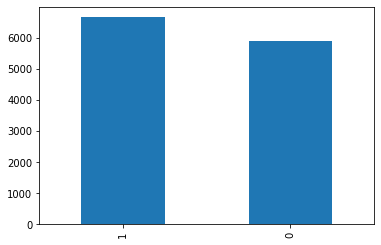

In [ ]:
train_df["ClassId"].value_counts().plot(kind = 'bar')
train_df["ClassId"].value_counts()

#Train_Test_Split

In [ ]:
def split(df):
  x_train,x_test,y_train,y_test=train_test_split(df.ImageId,df.ClassId,
                                               stratify=df.ClassId,
                                               random_state=7,
                                               test_size=0.3)
  
  train = pd.DataFrame(zip(x_train,y_train),columns=['ImageId','ClassId'])
  test = pd.DataFrame(zip(x_test,y_test),columns=['ImageId','ClassId'])
    
  return train,test

#Image Data Generator

In [ ]:
src_path_train = "/content/train_images/"

train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.30)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)
train,test=split(train_df)

Image Data Generator for Training

In [ ]:
batch_size = 32
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=src_path_train,
    x_col="ImageId",
    y_col="ClassId",
    target_size=(256, 256),
    batch_size=batch_size,
    color_mode='rgb',
    save_format='jpg',
    class_mode="binary",
    subset='training',
    shuffle=True,
    seed=42
)

Found 6158 validated image filenames belonging to 2 classes.


Image Data Generator for Validation Set

In [ ]:
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=src_path_train,
    x_col="ImageId",
    y_col="ClassId",
    target_size=(256, 256),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode="binary",
    subset='validation',
    shuffle=True,
    seed=42
)

Found 2639 validated image filenames belonging to 2 classes.


Image Data Generator for Testing

In [ ]:
testing = test_datagen.flow_from_dataframe(test,
    directory='/content/train_images',
    x_col='ImageId',
    y_col='ClassId',
    target_size=(256,256),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    save_format='jpg',
    interpolation='nearest',
    validate_filenames=True,
)

Found 3771 validated image filenames belonging to 2 classes.


#Attempt 1

Algorithm for  Sequential Model

In [ ]:
def prepare_model():
    model = Sequential()
    model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(256, 256, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])
    return model

Applying Earlysttoping, Model checkpointing

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

mc = ModelCheckpoint(filepath="/content/drive/MyDrive/SteelDefectDetection/Steel_model_ver2/modelseq2.h5",monitor="loss",verbose=1,save_best_only=True)
es = EarlyStopping(monitor='loss', min_delta = 0.001, patience=3,verbose=1)

cb = [mc,es]

Initializing the model and traing the model

In [ ]:
model = prepare_model()
model.fit(train_generator,
                    validation_data = valid_generator,
                    callbacks=cb,
                    epochs=5)

Epoch 1/5
193/193 [==============================] - ETA: 0s - loss: 0.8606 - accuracy: 0.6518
Epoch 1: loss improved from inf to 0.86056, saving model to /content/drive/MyDrive/SteelDefectDetection/Steel_model_ver2/modelseq.h5
193/193 [==============================] - 190s 925ms/step - loss: 0.8606 - accuracy: 0.6518 - val_loss: 0.5400 - val_accuracy: 0.7139
Epoch 2/5
193/193 [==============================] - ETA: 0s - loss: 0.5332 - accuracy: 0.7109
Epoch 2: loss improved from 0.86056 to 0.53324, saving model to /content/drive/MyDrive/SteelDefectDetection/Steel_model_ver2/modelseq.h5
193/193 [==============================] - 179s 928ms/step - loss: 0.5332 - accuracy: 0.7109 - val_loss: 0.5215 - val_accuracy: 0.7215
Epoch 3/5
193/193 [==============================] - ETA: 0s - loss: 0.5237 - accuracy: 0.7199
Epoch 3: loss improved from 0.53324 to 0.52367, saving model to /content/drive/MyDrive/SteelDefectDetection/Steel_model_ver2/modelseq.h5
193/193 [=============================

#Attempt 2

Algorithm for model and increased convolutional layer and applying dropout layer

In [ ]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(7,7), strides=2, input_shape=(256,256,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, input_shape=(256,256,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=16, kernel_size=(3,3), strides=1, input_shape=(256,256,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Flatten())
model.add(Dense(units=8, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','AUC','Precision','Recall'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 16)       0

Plot for Layer by Layer Parameters 

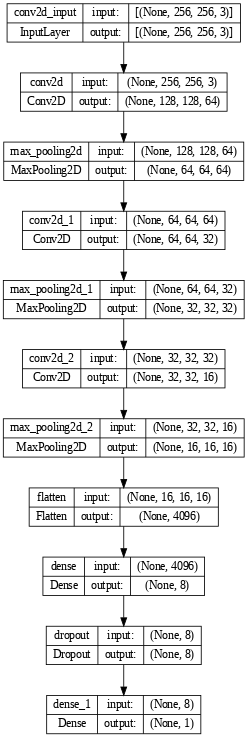

In [ ]:
plot_model(model, show_shapes=True, expand_nested=True, dpi=60)

Appling Early Stopping and Model Check Pointing 

In [ ]:


mc = ModelCheckpoint(filepath="/content/drive/MyDrive/SteelDefectDetection/Steel_model_ver2/modelseq2.h5",monitor="loss",verbose=1,save_best_only=True)
es = EarlyStopping(monitor='loss', min_delta = 0.001, patience=3,verbose=1)

cb = [mc,es]

Training the second version model 

In [ ]:
history=model.fit(train_generator,
                    validation_data = valid_generator,
                    callbacks=cb,
                    epochs=10)

Epoch 1/10
193/193 [==============================] - ETA: 0s - loss: 0.6452 - accuracy: 0.6038 - auc: 0.6607 - precision: 0.6127 - recall: 0.6874
Epoch 1: loss improved from inf to 0.64522, saving model to /content/drive/MyDrive/SteelDefectDetection/Steel_model_ver2/modelseq2.h5
193/193 [==============================] - 219s 1s/step - loss: 0.6452 - accuracy: 0.6038 - auc: 0.6607 - precision: 0.6127 - recall: 0.6874 - val_loss: 0.6263 - val_accuracy: 0.6036 - val_auc: 0.7613 - val_precision: 0.5821 - val_recall: 0.8964
Epoch 2/10
193/193 [==============================] - ETA: 0s - loss: 0.6084 - accuracy: 0.6656 - auc: 0.7322 - precision: 0.6658 - recall: 0.7422
Epoch 2: loss improved from 0.64522 to 0.60840, saving model to /content/drive/MyDrive/SteelDefectDetection/Steel_model_ver2/modelseq2.h5
193/193 [==============================] - 184s 953ms/step - loss: 0.6084 - accuracy: 0.6656 - auc: 0.7322 - precision: 0.6658 - recall: 0.7422 - val_loss: 0.5885 - val_accuracy: 0.7113 - 

Plotting AUC curve

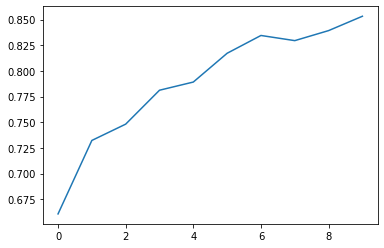

In [ ]:
plt.plot(history.history['auc'])

Plotting Validation Loss and Loss Curve

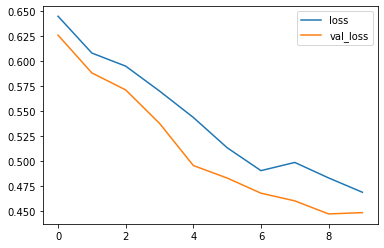

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])

Code for Saving the evaluation Parameters results

In [ ]:
model_history = { i:list(map(lambda x: float(x), j)) for i,j in history.history.items() }
with open('model_history.json', 'w') as f:
    json.dump(model_history, f, indent=4)

In [ ]:
losses = pd.DataFrame(model_history)
losses.index = map(lambda x : x+1, losses.index)
losses.head(10)

,loss,accuracy,auc,precision,recall,val_loss,val_accuracy,val_auc,val_precision,val_recall
1,0.645215,0.603767,0.660659,0.612718,0.687385,0.626307,0.603638,0.761332,0.582096,0.896429
2,0.608403,0.665638,0.732236,0.665751,0.742192,0.588519,0.711254,0.778062,0.714094,0.760000
3,0.595309,0.697142,0.748115,0.720769,0.700245,0.571531,0.698750,0.778367,0.705363,0.742143
4,0.570421,0.721176,0.781159,0.754854,0.702388,0.538094,0.754831,0.814811,0.794371,0.725714
5,0.544003,0.718090,0.789124,0.764157,0.677587,0.495894,0.755589,0.840604,0.772170,0.765000
6,0.513709,0.736440,0.817163,0.786536,0.690447,0.483402,0.763168,0.854618,0.848158,0.674286
7,0.490787,0.746021,0.834495,0.785762,0.716473,0.468225,0.751042,0.854862,0.829052,0.668571
8,0.498990,0.741962,0.829472,0.786863,0.704225,0.460553,0.775294,0.867045,0.851175,0.698571
9,0.483502,0.748620,0.839239,0.798679,0.703307,0.447496,0.766199,0.865797,0.795472,0.752857
10,0.469154,0.762748,0.853227,0.805621,0.728414,0.448761,0.779462,0.873939,0.840833,0.720714


#Predicting the results for testing set

In [ ]:
pred_probability = model.predict(testing,32)
predictions = pred_probability > 0.5

118/118 [==============================] - 33s 278ms/step


Here our label for defective is 1 and undefective is 0

so  
0 ---> False

1 ---> True

In [ ]:
print(predictions)

[[False]
 [False]
 [False]
 ...
 [False]
 [ True]
 [False]]


Converting results into actual labels

In [ ]:
prediction=[]
for i in range(0,len(predictions)):
  if predictions[i]==[False]:
    prediction.append(0)
  else:
    prediction.append(1)

In [ ]:
print(prediction)

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 

Mapping labels into 'defect' and 'un-defective'

In [ ]:
pred_class=[]
count_defect=0
count_undefect=0
for i in prediction:
  if i==0:
    pred_class.append('un-defective')
    count_undefect+=1
  else:
    pred_class.append('defective')
    count_defect+=1  

In [ ]:
print(count_defect)
print(count_undefect)
print(pred_class)

1723
2048
['un-defective', 'un-defective', 'un-defective', 'un-defective', 'un-defective', 'defective', 'defective', 'un-defective', 'defective', 'defective', 'un-defective', 'defective', 'defective', 'un-defective', 'un-defective', 'un-defective', 'un-defective', 'un-defective', 'defective', 'un-defective', 'defective', 'defective', 'un-defective', 'defective', 'un-defective', 'defective', 'defective', 'defective', 'defective', 'un-defective', 'un-defective', 'defective', 'defective', 'un-defective', 'un-defective', 'un-defective', 'defective', 'un-defective', 'defective', 'un-defective', 'defective', 'un-defective', 'un-defective', 'un-defective', 'defective', 'un-defective', 'defective', 'defective', 'un-defective', 'un-defective', 'un-defective', 'un-defective', 'un-defective', 'un-defective', 'un-defective', 'defective', 'un-defective', 'un-defective', 'un-defective', 'defective', 'un-defective', 'un-defective', 'un-defective', 'defective', 'defective', 'un-defective', 'un-defecti